# Ensemble clustering algorithms

## Imports

In [13]:
from sklearn.cluster import MiniBatchKMeans, KMeans, SpectralClustering
from simlarity_matrix import ClusterSimilarityMatrix, EnsembleCustering

from sklearn.datasets import make_moons, make_blobs
from scipy.sparse.csgraph import connected_components

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

## Example

Creating a complicated dataset: Non-gobular clusters with noise 

<AxesSubplot:>

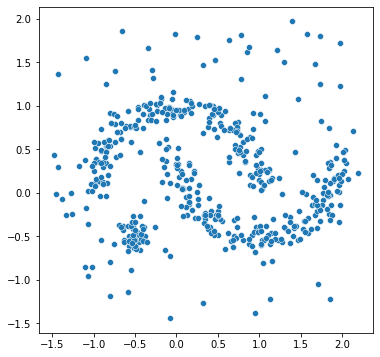

In [14]:
np.random.seed(214)
X_moons, _ = make_moons(n_samples=350, noise=0.1, random_state=214)
X_blobs, _ = make_blobs(n_samples=50, centers=[[-0.5,-0.5]], cluster_std=[0.1], random_state=214)
X_noise = np.random.uniform(low=-1.5, high=2.0, size=(100,2))

X_vectors = np.vstack([X_moons, X_blobs, X_noise])

fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(x=X_vectors[:,0], y=X_vectors[:,1], ax=ax)

## K-Means ensemble with Graph connected components

In [15]:
NUM_KMEANS = 32
MIN_PROBABILITY = 0.6

# Generating a "Cluster Forest"
clustering_models = NUM_KMEANS*[
    # Note: Do not set a random_state, as the variability is crucial
    # This is a extreme simple K-Means
    MiniBatchKMeans(n_clusters=16, batch_size=64, n_init=1, max_iter=20)
]

clt_sim_matrix = ClusterSimilarityMatrix()
for model in clustering_models:
    clt_sim_matrix.fit( model.fit_predict(X=X_vectors) ) 

sim_matrix = clt_sim_matrix.similarity
norm_sim_matrix = sim_matrix/sim_matrix.diagonal()

# Transforming the probabilities into graph edges
# This is very similar to DBSCAN
graph = (norm_sim_matrix>MIN_PROBABILITY).astype(int)

# Extractin the connected components
n_clusters, y_ensemble = connected_components( graph, directed=False, return_labels=True )

# Default K-Means
y_kmeans = KMeans(n_clusters=3).fit_predict(X_vectors)

Plotting

Text(0.5, 1.0, 'Default K-Means model(n_clusters=3)\n')

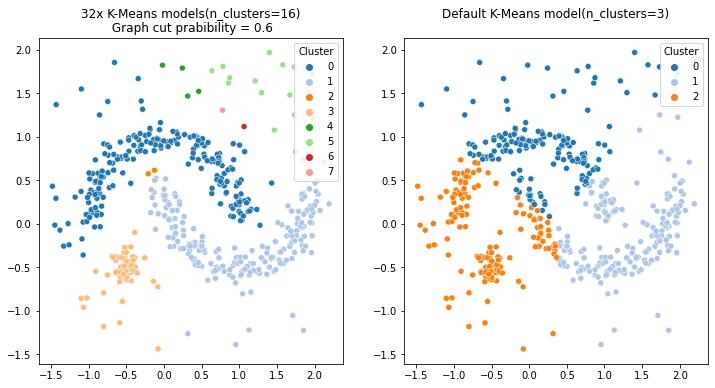

In [16]:
fig, ax = plt.subplots( figsize=(12,6), ncols=2 )

sns.scatterplot(
    x=X_vectors[:,0], 
    y=X_vectors[:,1], 
    hue=y_ensemble, 
    palette='tab20',
    ax=ax[0]
)

sns.scatterplot(
    x=X_vectors[:,0], 
    y=X_vectors[:,1], 
    hue=y_kmeans, 
    palette='tab20',
    ax=ax[1]
)

ax[0].legend(loc='upper right', title='Cluster')
ax[1].legend(loc='upper right', title='Cluster')

ax[0].set_title(f"{NUM_KMEANS}x K-Means models(n_clusters=16)\n Graph cut prabibility = {MIN_PROBABILITY}")
ax[1].set_title(f"Default K-Means model(n_clusters=3)\n")


## Spectral Clustering solo vs Spectral Clustering & K-Means 

In [17]:
NUM_KMEANS = 128

clustering_models = NUM_KMEANS*[
    # Note: Do not set a random_state, as the variability is crucial
    MiniBatchKMeans(n_clusters=16, batch_size=64, n_init=1, max_iter=20)
]
aggregator_clt = SpectralClustering(n_clusters=3, affinity="precomputed")

ens_clt=EnsembleCustering(clustering_models, aggregator_clt)
y_ensemble = ens_clt.fit_predict(X_vectors)

# Default Spectral Clustering model 
y_spectral = SpectralClustering(n_clusters=3).fit_predict(X_vectors)

Plotting

Text(0.5, 1.0, 'Default\nSpectralClustering(n_clusters=3)')

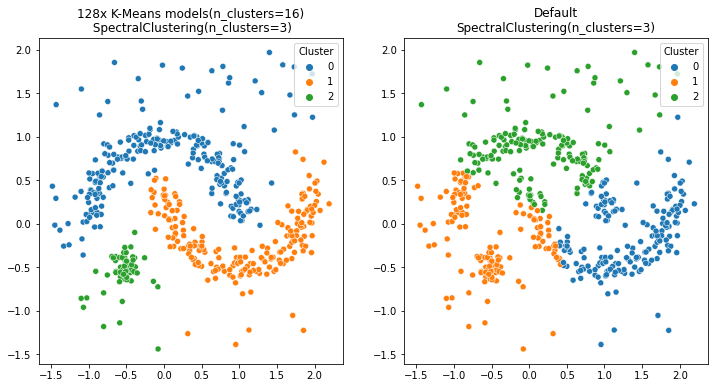

In [18]:
fig, ax = plt.subplots( figsize=(12,6), ncols=2 )

sns.scatterplot(
    x=X_vectors[:,0], 
    y=X_vectors[:,1], 
    hue=y_ensemble, 
    palette='tab10',
    ax=ax[0]
)

sns.scatterplot(
    x=X_vectors[:,0], 
    y=X_vectors[:,1], 
    hue=y_spectral, 
    palette='tab10',
    ax=ax[1]
)

ax[0].legend(loc='upper right', title='Cluster')
ax[1].legend(loc='upper right', title='Cluster')

ax[0].set_title(f"{NUM_KMEANS}x K-Means models(n_clusters=16)\n SpectralClustering(n_clusters=3)")
ax[1].set_title(f"Default\nSpectralClustering(n_clusters=3)")
